# Image Classification for Amazon Products

**Purpose**:

Image classification is a crucial task for online marketplaces such as Amazon, which rely on images to showcase their products to customers. Amazon has a vast array of products, from electronics to clothing, and image classification can help to accurately categorize these products. In this proposal, we will discuss a machine-learning project for the image classification of Amazon products.
Specifically, we will use our own customized web scraping tool to download thousands of images for a range of human wearable products, including Earbuds, VR sets, Fitness trackers, Hearing Aids, Watches, Sunglasses, and Hats. Our purpose is to build a model that can accurately classify the products in the images.


**Methodology**:

The first step in this project is data preprocessing. The images are resized to a standard size, and the pixel values are normalized to a range of [0, 1]. The images are also labelled based on the product category to which they belong. Then, the data is split into training and validation sets, where the training set is used to train the model, and the validation set is used to evaluate the performance of the model during training.
As an exploration step, we will first use some conventional machine learning models like logistic regression, K-nearest neighbours (KNN), support vector machines (SVM), and Gaussian Bayes Classifier. The model is trained using the labelled images, and its performance is evaluated on a separate validation dataset with a cross-validation technique. To reduce computational power, there is a dimensionality reduction method using principal component analysis (PCA) on top of each training model. PCA can be used to reduce the dimensionality of the image data by identifying the most important pixels. This can improve the efficiency of machine learning algorithms and reduce overfitting. Eventually, each trained model is then used to classify new images into their respective product categories.
Contrary to conventional machine learning models, we will also use deep learning methods like Convolutional Neural Networks (CNN) to classify images, which is probably a better way to deal with complex datasets. This method will be covered in the later classes, the general idea here is the model applies convolutional filters to the input image, which extract features at different spatial scales. The extracted features are then fed into a series of fully connected layers that perform the classification task. The output of the model is a softmax layer that predicts the probability distribution over the product categories.


First we will try a range of conventional machine learning models like Random Forest Classifier, KNN, Decision Tree Classifier, and Naive Bayes classifier. Later on we will also implement Deep Learning like CNN.

The overall layout for this analysis is:
1. import all required packages
2. Load the data and label each image
3. Visualialize some figures and process them
4. Try differetnt machine learning modesl, find the best hypter parameters, and evaluate respective performance
5. Use the trained model to do some prediction

## Load required packages

In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

from pathlib import Path
import os
import re

#need to pip install opencv-python
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm

In [2]:
#Get the total classes we have
class_names = [class_name for class_name in os.listdir("./images") if not class_name.startswith(".")]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)
print(f"We have in total {nb_classes} different classes."+
      f"\nAnd they are:\n {', '.join(classes for classes in class_names)}.")

We have in total 12 different classes.
And they are:
 tshirt, sunglasses, watches, speaker, chair, pens, shorts, phone, earbuds, hat, shoes, bottle.


## Explore cv2 package

The original image has shape of (150, 150, 3) with datatype of uint8:


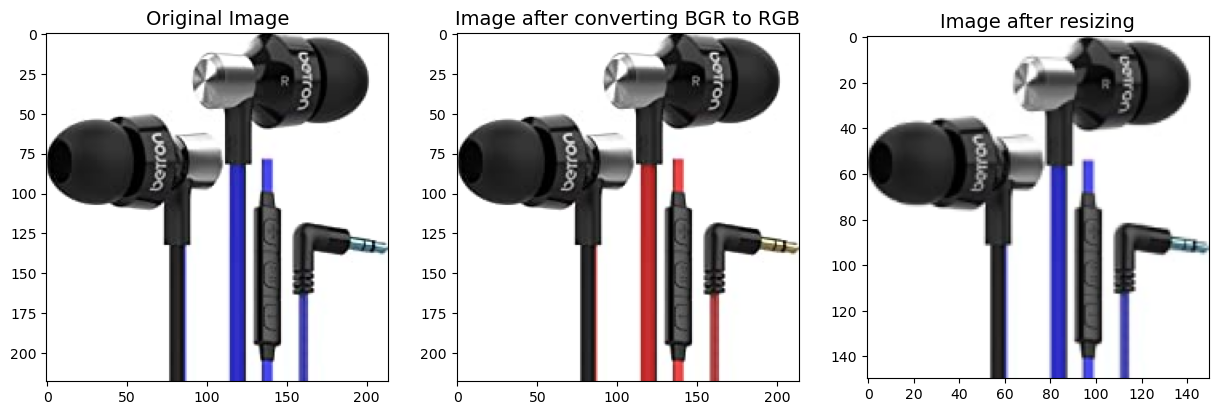

In [121]:
# '''
# OS.walk() generate the file names in a directory tree by walking the tree either top-down or bottom-up.
# For each directory in the tree rooted at directory top (including top itself), 
# it yields a 3-tuple (dirpath, dirnames, filenames).
# For example, we have 12 folder in ./images, it will loop through 13 times = root + 12 folders
# Read more in https://www.geeksforgeeks.org/os-walk-python/
# '''
# class_name = []
# for root, dirs, files in os.walk("./images", topdown = True):
#     for name in files:
#         print(os.path.join(root, name))

# for i in range(10):
#     plt.imshow(images[i].astype('uint8'))

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
#Read in one image and show them
test_img1 = cv2.imread("./images/earbuds/615MxN+QWzL._AC_UY218_.jpg")
#The original image
print(f"The original image has shape of {test_img.shape} with datatype of {test_img.dtype}:")
axes[0].imshow(test_img1)
axes[0].set_title("Original Image", fontsize=14)
#After change the color space from BGR to RGB
'''
When the image file is read with the OpenCV function imread(), the order of colors is BGR (blue, green, red). 
On the other hand, in Pillow, the order of colors is assumed to be RGB (red, green, blue).
Therefore, if you want to use both the Pillow function and the OpenCV function, you need to convert BGR and RGB.
'''
'''
When reading a color image file, OpenCV imread() reads as a NumPy array ndarray of 
row (height) x column (width) x color (3). The order of color is BGR (blue, green, red).
read more in https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/
'''
test_img2 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)
axes[1].imshow(test_img2)
axes[1].set_title("Image after converting BGR to RGB", fontsize=14)
'''
OpenCV provides the function cv2. resize() to resize an image. Resizing in OpenCV 
is referred to as scaling. We can resize an image by specifying the image size or scaling factor. 
The aspect ratio is preserved when we specify the scaling factor.
'''
test_img3 = cv2.resize(test_img1, (150,150))
axes[2].imshow(test_img3)
axes[2].set_title("Image after resizing", fontsize=14)
plt.show()

## Load Data

In [69]:
#Load the data from each folder
def load_image_from_folder(root_dir):

    images = []
    labels = []
    IMAGE_SIZE = (150, 150)

    for folder in os.listdir(root_dir):
        #Because there are some configure file also sitting there
        if folder.startswith("."):
            continue
        label = class_names_label[folder]
        for file in os.listdir(os.path.join(root_dir, folder)):
            # Get the path name of the image
            if file.startswith("."):
                continue
            img_path = os.path.join(root_dir, folder, file)
            #open and resize the image, read in as 3d array
            '''
            The reason we add try except is because some iamges just cannot be read in to cv2
            for example this one: ./updated images/watches/712+lS1mk-L._AC_UL320_.jpg
            I dont know why.
            
            Also, there are some corrupted images like this one: ./updated images/watches/814cT4PAxeL._AC_UL320_.jpg
            However, cv2 wont allow us to capture this images. We will still keep them in our image pool,
            because they dont really cause any issue.
            
            If you do want learn more read https://medium.com/joelthchao/programmatically-detect-corrupted-image-8c1b2006c3d3
            and
            https://scikit-image.org/
            '''
            try:
                image = cv2.imread(img_path)
                #cv2.cvtColor() method is used to convert an image from one color space to another.
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #OpenCV provides the function cv2. resize() to resize an image. Resizing in OpenCV 
                #is referred to as scaling. We can resize an image by specifying the image size or scaling factor. 
                #The aspect ratio is preserved when we specify the scaling factor.
                image = cv2.resize(image, IMAGE_SIZE)
            except:
                continue

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)
    # The original dtypes of image is uint8 (Unsigned integer type, from 0 to 18_446_744_073_709_551_615)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return ((images, labels))

images, labels = load_image_from_folder('./images')
updated_images, updated_labels = load_image_from_folder('./updated images')

#merge these two pool images together
images_m = np.concatenate((images, updated_images), axis=0)
labels_m = np.concatenate((labels, updated_labels))

#Shuffle arrays or sparse matrices in a consistent way.
#This is a convenience alias to resample(*arrays, replace=False) to do random permutations of the collections.
#otherwise imaages are grouped all together based on their classes
images_r, labels_r = shuffle(images_m, labels_m, random_state=25)

Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 250 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 3186 extraneous bytes before marker 0xc4
Corrupt JPEG data: 3272 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 269 extraneous bytes before marker 0xc4
Corrupt JPEG data: 4436 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 897 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2472 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


## How to find duplicated images
Since we are pulling more images from Amazon Country, maybe there are some duplicated images. We will write a function to find those images and only keep one of duplicated images.

## Visualization

How many images in each class?


,,,,,,,,,,,,
Class,bottle,chair,earbuds,hat,pens,phone,shoes,shorts,speaker,sunglasses,tshirt,watches
Total Amount,688,967,654,976,990,909,1106,921,662,817,959,947


Each image size is: (150, 150).


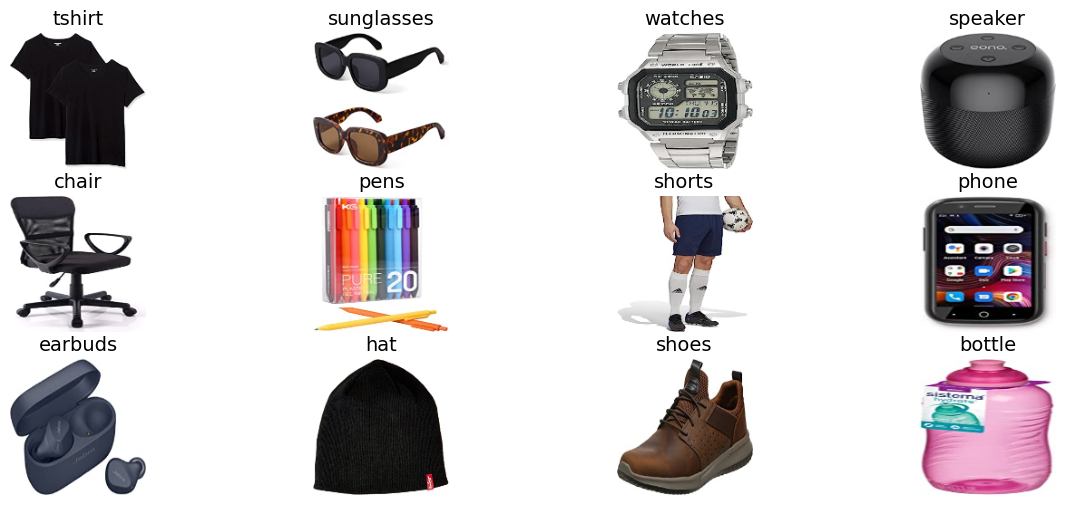

In [79]:
'''
How many images in each class?
'''
print("How many images in each class?")
class_name, count_name = np.array(np.unique(np.array(class_names)[labels_r], return_counts=True))
total_images = pd.DataFrame((class_name, count_name), 
             index = ["Class", "Total Amount"], columns = ['']*len(name))
display(total_images)

print(f"Each image size is: {IMAGE_SIZE}.")

#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    #This will only look at one image for each different category
    x = images_r[labels_r == i][0].astype('uint8')
    ax.imshow(x)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)
    

## Preprocessing
Normalization is a common step of image pre-processing and is achieved by simply dividing images by 255.0. This is essential to maintain the pixels of all the images within a uniform range.

The shape of images is in 4 dimensions like (3888, 150, 150, 3)=(nsamples, nx, ny, nrgb) , meaing there are total 3888 images and each image has (150, 150, 3) shape, but the Sklearn machine leraning models are expecting 2 dimensions, with row as each image information.

Read more in https://www.analyticsvidhya.com/blog/2022/01/image-classification-using-machine-learning/

In [81]:
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r, labels_r, test_size=0.2, random_state=2023)
# # Normalization
# X_train_norm = X_train/255.0
# X_test_norm = X_test/255.0
#reshape
nsamples, nx, ny, nrgb = X_train.shape
X_train = X_train.reshape((nsamples, nx*ny*nrgb))
nsamples, nx, ny, nrgb = X_test.shape
X_test = X_test.reshape((nsamples, nx*ny*nrgb))

## Implementing different machine learning models
1. Logistic regression
2. K-Nearest Neighbours
3. LDA / QDA / Gaussian Naive Bayes
4. PCA (will be used to combine with other method)
5. Support Vector Machine
6. Trees (DecisionTreeClassifier, Bagging and Random Forests, Boosting, Bayesian Additive Regression Trees (BART))
7. Neural Networks

Each method we need to do cross validation (Kfold), hyper parameter tunning methods, or CVGridSearch

In [82]:
#Standardlize the data before fitting into model
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)
print("The accuracy rate using logistic regression is", pipe.score(X_test, y_test))

/Users/yongpengfu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy rate using logistic regression is 0.8594339622641509
